Problem:

$$\min_{\mu_t} \sum_{t=0}^{T} \left( \Delta(Q_t) + V \cdot P(\mu_t) \right)$$

Subject to:

\begin{aligned}
& Q_{t+1} = \max(Q_t + A_t - \mu_t, 0) \\
& A_t \sim \text{Poisson}(\lambda), \quad \lambda = 3 \\
& \sum_{t=0}^{T} \mu_t \leq 400 \quad \text{(Energy budget)} \\
& Q_t \leq 20 \quad \forall t \quad \text{(Delay constraint)} \\
& 0 \leq \mu_t \leq 5 \quad \forall t \quad \text{(Service rate limits)}
\end{aligned}

Where:\
item $Q_t$: queue size at time $t$\
item $A_t$: random arrivals at time $t$\
item $\mu_t$: service rate (control variable)\
item $V$: control parameter balancing stability and cost



In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from kan import KAN
import time

In [14]:
T = 1000             
V = 10               
initialQueue = 0     
maxService = 5       
arrivalMean = 3      
energyBudget = 400 
maxDelay = 20        
windowSize = 5    
jumpThreshold = 1

def generateStochasticSamples(tSteps=1000, seed=np.random.randint(0,999)):
    np.random.seed(seed)
    queue = initialQueue
    energy = 0
    pastArrivals = np.zeros(windowSize)
    inputs = []
    targets = []
    for i in range(tSteps):
        arrivals = np.random.poisson(arrivalMean)
        serviceRate = min(queue / V, maxService) if queue > 0 else 0

        if energy + serviceRate > energyBudget:
            serviceRate = max(0, energyBudget - energy)
        if queue > maxDelay:
            serviceRate = min(maxService, queue)

        serviceRate = max(0, min(serviceRate, maxService))
        stateVec = np.concatenate(([queue, energy], pastArrivals))
        inputs.append(stateVec)
        targets.append(serviceRate)

        queue = max(queue + arrivals - serviceRate, 0)
        energy += serviceRate
        pastArrivals = np.roll(pastArrivals, -1)
        pastArrivals[-1] = arrivals

        if energy >= energyBudget:
            break

    return np.array(inputs), np.array(targets)


In [30]:
xTest, yTest = generateStochasticSamples(tSteps=T, seed=0)
queue = 0
energy = 0
pastArrivals = np.zeros(windowSize)
analyticalQueueSizes = []
analyticalServiceRates = []
analyticalEnergyUsed = 0
analyticalJumpCount = 0
prevServiceRate = 0
analyticalBudgetReachedStep = 0
for step in range(xTest.shape[0]):
    if analyticalEnergyUsed >= energyBudget:
        analyticalBudgetReachedStep = step
        break

    queue = xTest[step, 0]
    energy = xTest[step, 1]
    pastArrivals = xTest[step, 2:]

    serviceRate = min(queue / V, maxService) if queue > 0 else 0
    if energy + serviceRate > energyBudget:
        serviceRate = max(0, energyBudget - energy)
    if queue > maxDelay:
        serviceRate = min(maxService, queue)
    serviceRate = max(0, min(serviceRate, maxService))

    #jump count calculation
    if abs(serviceRate - prevServiceRate) > jumpThreshold:
        analyticalJumpCount += 1
    prevServiceRate = serviceRate

    analyticalQueueSizes.append(queue)
    analyticalServiceRates.append(serviceRate)
    analyticalEnergyUsed += serviceRate

if analyticalBudgetReachedStep == 0:
    analyticalBudgetReachedStep = len(analyticalServiceRates)

analyticalAvgQueue = np.mean(analyticalQueueSizes)
analyticalAvgService = np.mean(analyticalServiceRates)
analyticalTotalEnergy = analyticalEnergyUsed

print(f"Average Queue Size:    {analyticalAvgQueue:.2f}")
print(f"Average Service Rate:  {analyticalAvgService:.2f}")
print(f"Total Energy Used:     {analyticalTotalEnergy:.2f} / {energyBudget}")
print(f"Jump Count:            {analyticalJumpCount} (jump threshold > {jumpThreshold})")
print(f"Energy Budget Reached At Step: {analyticalBudgetReachedStep}")


Average Queue Size:    18.95
Average Service Rate:  2.85
Total Energy Used:     404.50 / 400
Jump Count:            55 (jump threshold > 1)
Energy Budget Reached At Step: 142


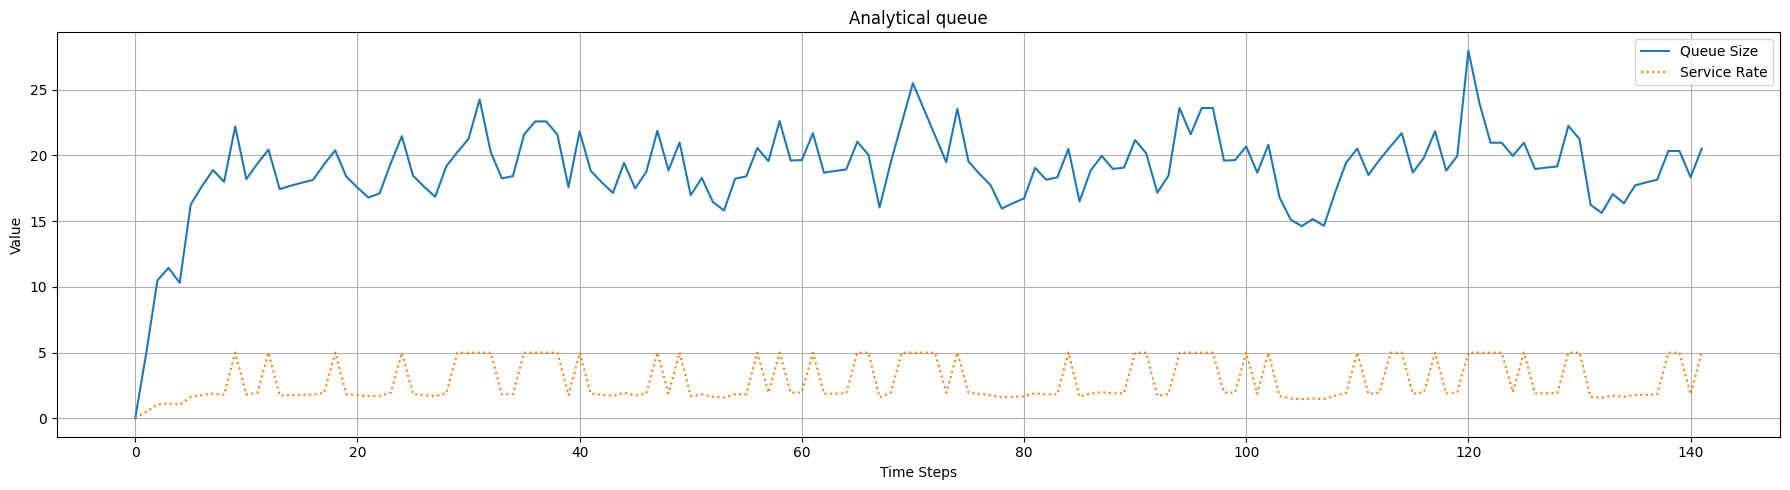

In [16]:
plt.figure(figsize=(18, 5))
plt.plot(analyticalQueueSizes, label="Queue Size")
plt.plot(analyticalServiceRates, label="Service Rate", linestyle="dotted")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.title("Analytical queue")
plt.grid()
plt.tight_layout()
plt.show()

In [58]:
class MLP(nn.Module):
    def __init__(self, inputDim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(inputDim, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

mlpLossesAll = []
mlpSummary = []
mlpNRuns = 5
mlpEpochs = 1000
mlpTestTargets = []

for run in range(mlpNRuns):

    mlpXTrain, mlpYTrain = generateStochasticSamples(tSteps=T)
    mlpXTensor = torch.tensor(mlpXTrain, dtype=torch.float32)
    mlpYTensor = torch.tensor(mlpYTrain, dtype=torch.float32).view(-1, 1)

    mlpModel = MLP(mlpXTrain.shape[1])
    mlpOptimiser = optim.Adam(mlpModel.parameters(), lr=0.001)
    mlpRunLosses = []

    #train
    mlpStartTime = time.time()
    for epoch in range(mlpEpochs):
        mlpOptimiser.zero_grad()
        mlpPredictions = mlpModel(mlpXTensor)
        mlpLoss = nn.MSELoss()(mlpPredictions, mlpYTensor)
        mlpLoss.backward()
        mlpOptimiser.step()
        mlpRunLosses.append(mlpLoss.item())
    mlpEndTime = time.time()

    #test
    mlpQueue = 0
    mlpEnergy = 0
    mlpPastArrivals = np.zeros(windowSize)
    mlpQueueSizes = []
    mlpServiceRates = []
    mlpJumpCount = 0
    mlpPrevService = 0

    mlpXTest, mlpYTest = generateStochasticSamples(tSteps=T, seed=0)
    mlpTestTargets.append(mlpYTest)
    mlpBudgetReachedStep = 0
    for step in range(mlpXTest.shape[0]):
        if mlpEnergy >= energyBudget:
            mlpBudgetReachedStep = step
            break

        inputVec = torch.tensor(mlpXTest[step], dtype=torch.float32).view(1, -1)

        with torch.no_grad():
            mlpService = mlpModel(inputVec).item()

        if mlpEnergy + mlpService > energyBudget:
            mlpService = max(0, energyBudget - mlpEnergy)
        if mlpXTest[step, 0] > maxDelay:
            mlpService = min(maxService, mlpXTest[step, 0])
        mlpService = max(0, min(mlpService, maxService))

        if abs(mlpService - mlpPrevService) > 1.0:
            mlpJumpCount += 1
        mlpPrevService = mlpService

        mlpQueueSizes.append(mlpXTest[step, 0])
        mlpServiceRates.append(mlpService)
        mlpEnergy += mlpService

    mlpLossesAll.append(mlpRunLosses)
    mlpSummary.append({
        "avgQueue": np.mean(mlpQueueSizes),
        "avgService": np.mean(mlpServiceRates),
        "totalEnergy": mlpEnergy,
        "jumpCount": mlpJumpCount,
        "finalLoss": mlpRunLosses[-1],
        "time": mlpEndTime - mlpStartTime,
        "budgetReachedStep": mlpBudgetReachedStep
    })

mlpAvgQueue = np.mean(mlpQueueSizes)
mlpAvgService = np.mean(mlpServiceRates)
mlpTotalEnergy = mlpEnergy

print(f"Average Queue Size:    {mlpAvgQueue:.2f}")
print(f"Average Service Rate:  {mlpAvgService:.2f}")
print(f"Total Energy Used:     {mlpTotalEnergy:.2f} / {energyBudget}")
print(f"Jump Count:            {mlpJumpCount} (jump threshold > {jumpThreshold})")
print(f"Energy Budget Reached At Step: {mlpBudgetReachedStep}")

Average Queue Size:    18.96
Average Service Rate:  3.20
Total Energy Used:     400.00 / 400
Jump Count:            62 (jump threshold > 1)
Energy Budget Reached At Step: 125


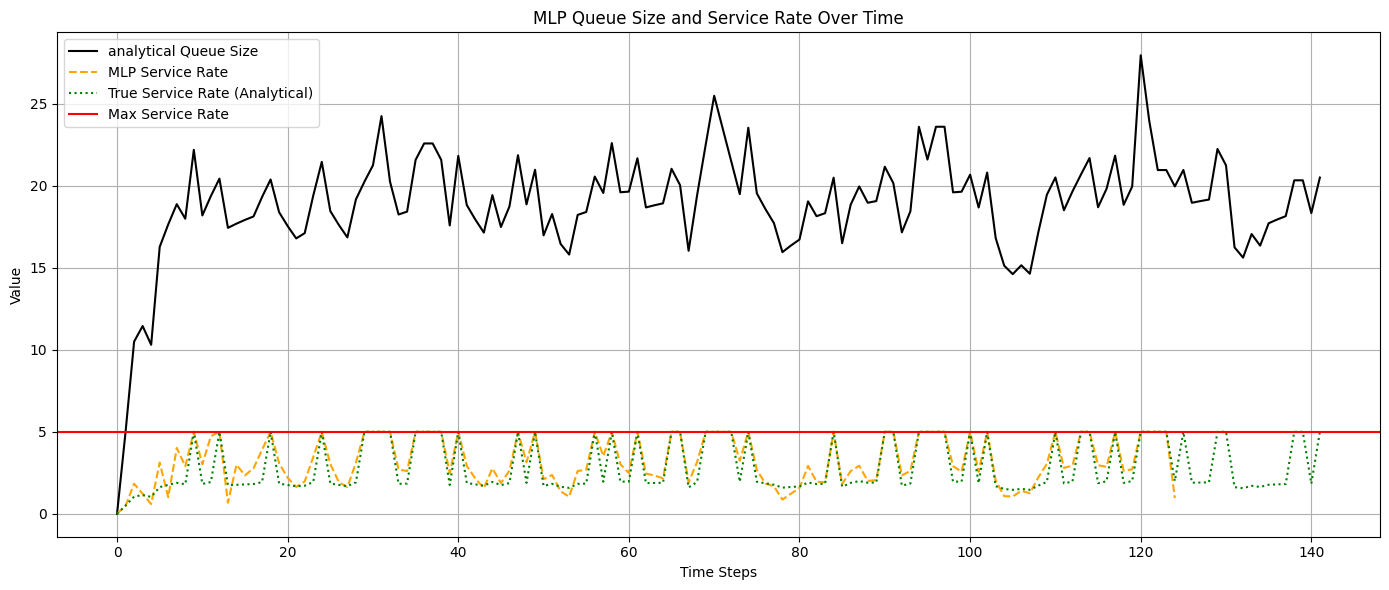

In [59]:
plt.figure(figsize=(14, 6))
#plt.plot(mlpQueueSizes, label="MLP Queue Size", color='blue')
plt.plot(analyticalQueueSizes, label="analytical Queue Size", color='black')
plt.plot(mlpServiceRates, label="MLP Service Rate", linestyle='--', color='orange')

#plt.plot(analyticalServiceRates, label="True Service Rate (Analytical)", linestyle=':', color='green')
plt.plot(mlpTestTargets[0], label="True Service Rate (Analytical)", linestyle=':', color='green')
plt.axhline(maxService, color='red', label="Max Service Rate")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("MLP Queue Size and Service Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

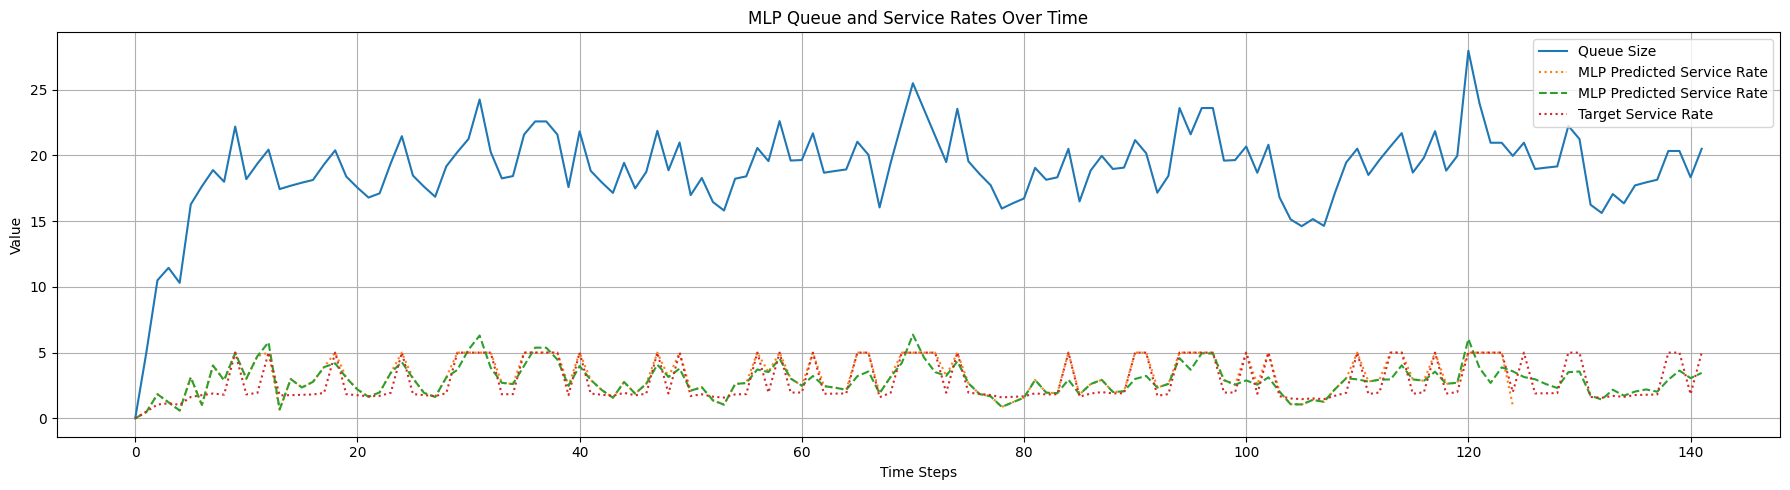

In [60]:
xTrain, yTrain = generateStochasticSamples(tSteps=T, seed=0)
xTensor = torch.tensor(xTrain, dtype=torch.float32)

mlpModel.eval()
with torch.no_grad():
    mlpServiceRates2 = mlpModel(xTensor).squeeze().detach().numpy()
queueSizes = xTrain[:, 0]

plt.figure(figsize=(18, 5))
plt.plot(queueSizes, label="Queue Size")
plt.plot(mlpServiceRates, label="MLP Predicted Service Rate", linestyle="dotted")
plt.plot(mlpServiceRates2, label="MLP Predicted Service Rate", linestyle="--")
plt.plot(yTrain, label="Target Service Rate", linestyle="dotted")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.title("MLP Queue and Service Rates Over Time")
plt.grid()
plt.tight_layout()
plt.show()


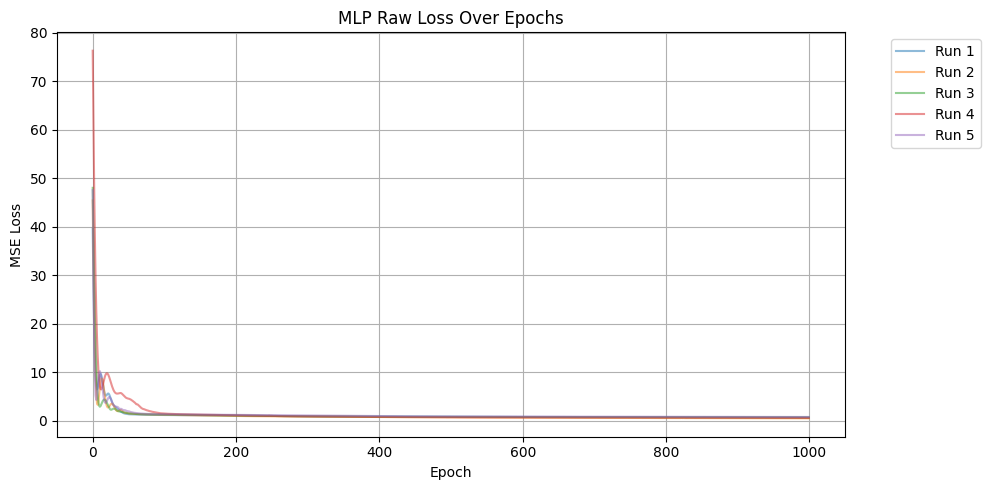

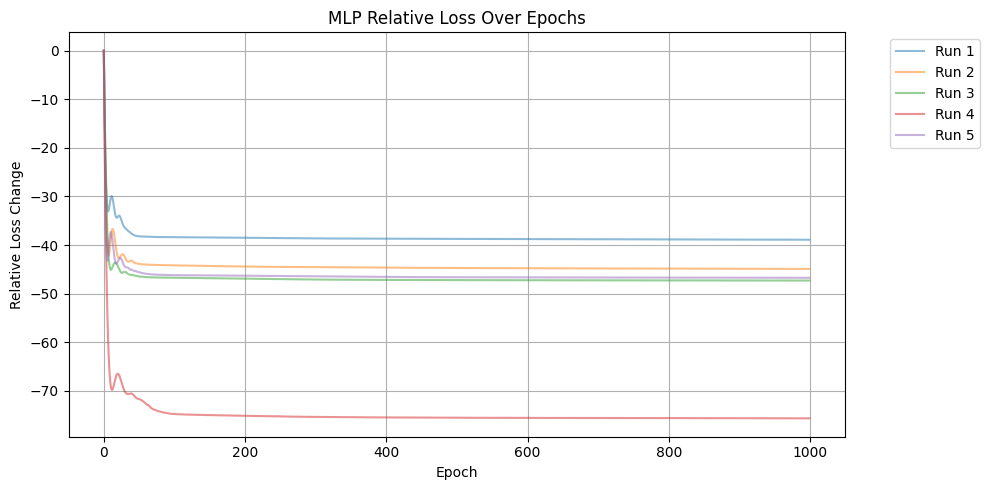

In [61]:
plt.figure(figsize=(10, 5))
for i, losses in enumerate(mlpLossesAll):
    plt.plot(losses, label=f"Run {i+1}", alpha=0.5)
plt.title("MLP Raw Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, losses in enumerate(mlpLossesAll):
    initial_loss = losses[0]
    relative_losses = [l - initial_loss for l in losses]
    plt.plot(relative_losses, label=f"Run {i+1}", alpha=0.5)
plt.title("MLP Relative Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Relative Loss Change")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
kanNRuns = 5
kanLossesAll = []
kanSummary = []
kanEpochs = 1000

for run in range(kanNRuns):
    xTrain, yTrain = generateStochasticSamples(T, seed=run)
    xTensor = torch.tensor(xTrain, dtype=torch.float32)
    yTensor = torch.tensor(yTrain, dtype=torch.float32)

    kModel = KAN(width=[xTrain.shape[1], 6, 6, 1], grid=5, k=3, seed=run)
    optimiserKAN = optim.Adam(kModel.parameters(), lr=0.001)
    runLosses = []

    startTime = time.time()
    for epoch in range(kanEpochs):
        kModel.train()
        optimiserKAN.zero_grad()
        predictions = kModel(xTensor).squeeze()
        mse = torch.mean((predictions - yTensor)**2)
        boundsPenalty = torch.mean(torch.relu(predictions - maxService) + torch.relu(-predictions))
        loss = mse + 10 * boundsPenalty
        loss.backward()
        optimiserKAN.step()
        runLosses.append(loss.item())

    endTime = time.time()
    queue = initialQueue
    energy = 0
    pastArrivals = np.zeros(windowSize)
    queueSizes = []
    serviceRates = []
    jumpCount = 0
    prevService = 0
    kanBudgetReachedStep = 0

    for t in range(T):
        if energy >= energyBudget:
            kanBudgetReachedStep = step
            break
        arrivals = np.random.poisson(arrivalMean)
        inputVec = torch.tensor(np.concatenate(([queue, energy], pastArrivals)), dtype=torch.float32).view(1, -1)

        with torch.no_grad():
            service = kModel(inputVec).item()

        if energy + service > energyBudget:
            service = max(0, energyBudget - energy)
        if queue > maxDelay:
            service = min(maxService, queue)
        service = max(0, min(service, maxService))

        #jump count calculation
        if abs(service - prevService) > 1.0:
            jumpCount += 1
        prevService = service

        queue = max(queue + arrivals - service, 0)
        energy += service
        pastArrivals = np.roll(pastArrivals, -1)
        pastArrivals[-1] = arrivals

        queueSizes.append(queue)
        serviceRates.append(service)

    kanLossesAll.append(runLosses)
    kanSummary.append({
        "avgQueue": np.mean(queueSizes),
        "avgService": np.mean(serviceRates),
        "totalEnergy": energy,
        "jumpCount": jumpCount,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "budgetReachedStep": kanBudgetReachedStep
    })

kanAvgQueue = [s["avgQueue"] for s in kanSummary]
kanAvgService = [s["avgService"] for s in kanSummary]
kanTotalEnergy = [s["totalEnergy"] for s in kanSummary]
kanJumpCount = [s["jumpCount"] for s in kanSummary]
kanFinalLoss = [s["finalLoss"] for s in kanSummary]
kanTimes = [s["time"] for s in kanSummary]
kanBudgetReachedSteps = [s["budgetReachedStep"] for s in kanSummary]

print(f"Average Queue Size:    {kanAvgQueue}")
print(f"Average Service Rate:  {kanAvgService}")
print(f"Total Energy Used:     {kanTotalEnergy} / {energyBudget}")
print(f"Jump Count:            {kanJumpCount} (jump threshold > {jumpThreshold})")
print(f"Energy Budget Reached At Step: {kanBudgetReachedStep}")

checkpoint directory created: ./model
saving model version 0.0


c:\Users\A\VSCodeRepos\Investigating-mathematical-optimisation-using-KANs\.venv\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\A\VSCodeRepos\Investigating-mathematical-optimisation-using-KANs\.venv\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\A\VSCodeRepos\Investigating-mathematical-optimisation-using-KANs\.venv\Lib\site-packages

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Average Queue Size:    [np.float64(18.56167068189763), np.float64(17.5916942936911), np.float64(18.088683823887393), np.float64(15.971576924161088), np.float64(17.078769766471602)]
Average Service Rate:  [np.float64(2.8368794326241136), np.float64(2.8776978417266186), np.float64(2.8776978417266186), np.float64(2.8776978417266186), np.float64(3.0303030303030303)]
Total Energy Used:     [400.0, 400.0, 400.0, 400.0, 400.0] / 400
Jump Count:            [54, 80, 60, 61, 50] (jump threshold > 1)
Energy Budget Reached At Step: 125


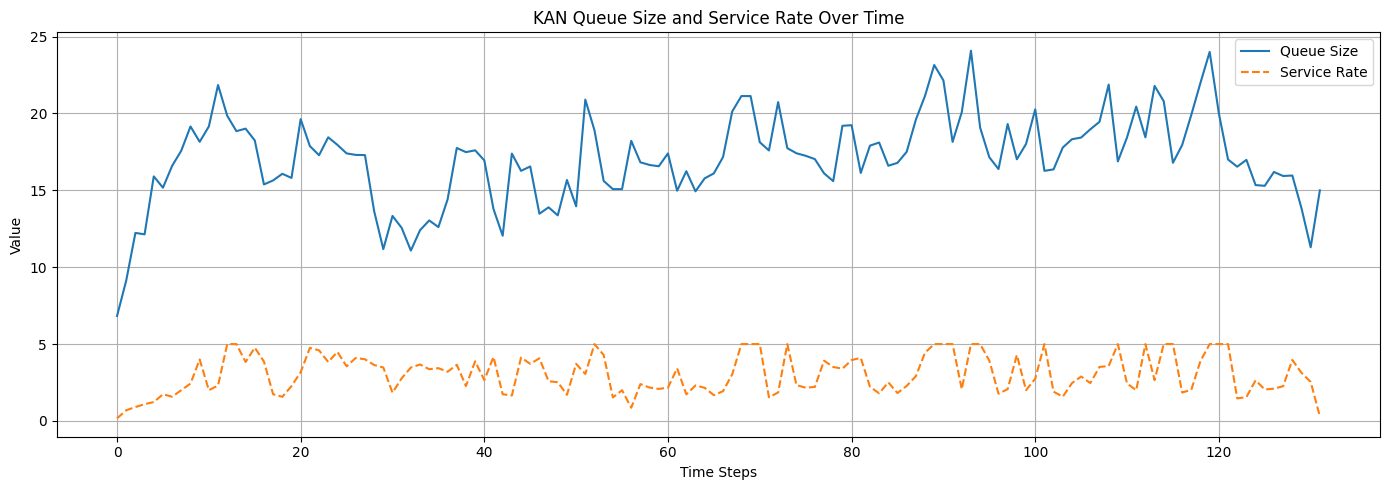

In [64]:
plt.figure(figsize=(14, 5))
plt.plot(queueSizes, label="Queue Size")
plt.plot(serviceRates, label="Service Rate", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("KAN Queue Size and Service Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

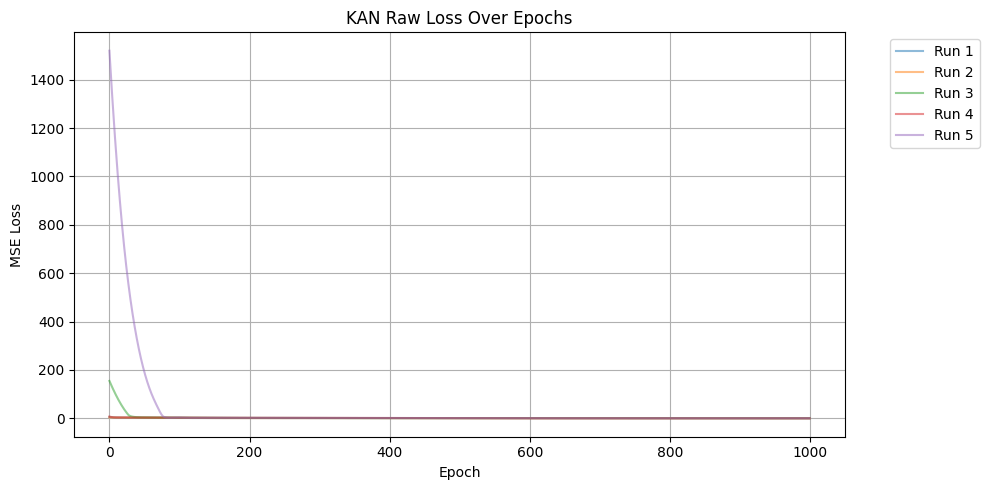

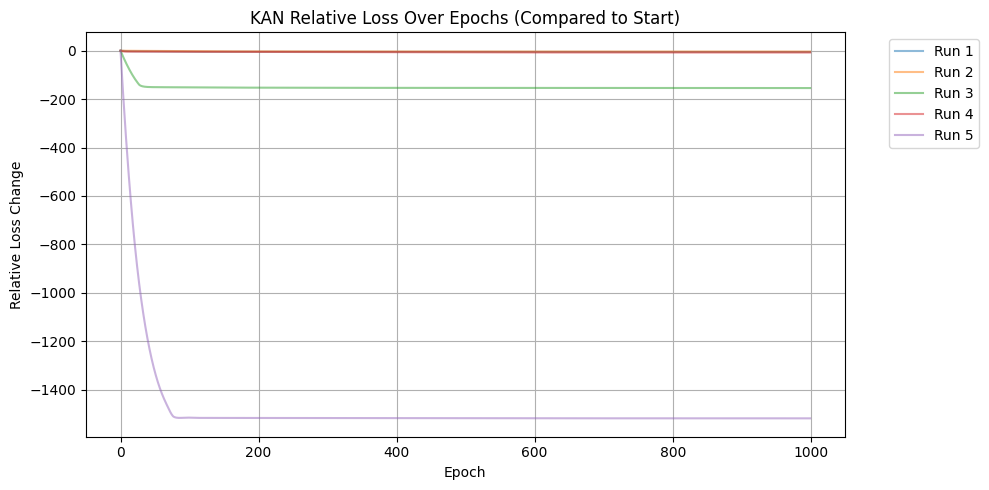

In [ ]:
#raw loss
plt.figure(figsize=(10, 5))
for i, losses in enumerate(kanLossesAll):
    plt.plot(losses, label=f"Run {i+1}", alpha=0.5)
plt.title("KAN Raw Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
for i, losses in enumerate(kanLossesAll):
    initial_loss = losses[0]
    relative_losses = [l - initial_loss for l in losses]
    plt.plot(relative_losses, label=f"Run {i+1}", alpha=0.5)
plt.title("KAN Relative Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Relative Loss Change")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mlpAvgQueues = [r["avgQueue"] for r in mlpSummary]
mlpAvgServices = [r["avgService"] for r in mlpSummary]
mlpTotalEnergies = [r["totalEnergy"] for r in mlpSummary]
mlpJumpCounts = [r["jumpCount"] for r in mlpSummary]
mlpFinalLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]

kanAvgQueues = [r["avgQueue"] for r in kanSummary]
kanAvgServices = [r["avgService"] for r in kanSummary]
kanTotalEnergies = [r["totalEnergy"] for r in kanSummary]
kanJumpCounts = [r["jumpCount"] for r in kanSummary]
kanFinalLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]

comparisonData = {
    "Metric": [
        "Mean Queue Size",
        "Std Queue Size",
        "Mean Service Rate",
        "Std Service Rate",
        "Total Energy Used (Mean)",
        "Jump Count (Mean)",
        "Mean Final Loss",
        "Training Time (s)"
    ],
    "MLP": [
        np.mean(mlpAvgQueues),
        np.std(mlpAvgQueues),
        np.mean(mlpAvgServices),
        np.std(mlpAvgServices),
        np.mean(mlpTotalEnergies),
        np.mean(mlpJumpCounts),
        np.mean(mlpFinalLosses),
        np.mean(mlpTimes)
    ],
    "KAN": [
        np.mean(kanAvgQueues),
        np.std(kanAvgQueues),
        np.mean(kanAvgServices),
        np.std(kanAvgServices),
        np.mean(kanTotalEnergies),
        np.mean(kanJumpCounts),
        np.mean(kanFinalLosses),
        np.mean(kanTimes)
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
print("\n=== Full Metric Comparison: MLP vs KAN ===")
display(comparisonDf)



=== Full Metric Comparison: MLP vs KAN ===


,Metric,MLP,KAN
0,Mean Queue Size,18.963141,17.458479
1,Std Queue Size,0.020900,0.892972
2,Mean Service Rate,3.198799,2.900055
3,Std Service Rate,0.049452,0.067015
4,Total Energy Used (Mean),400.394250,400.000000
5,Jump Count (Mean),67.000000,61.000000
6,Mean Final Loss,0.679790,0.468642
7,Training Time (s),2.472747,136.107064


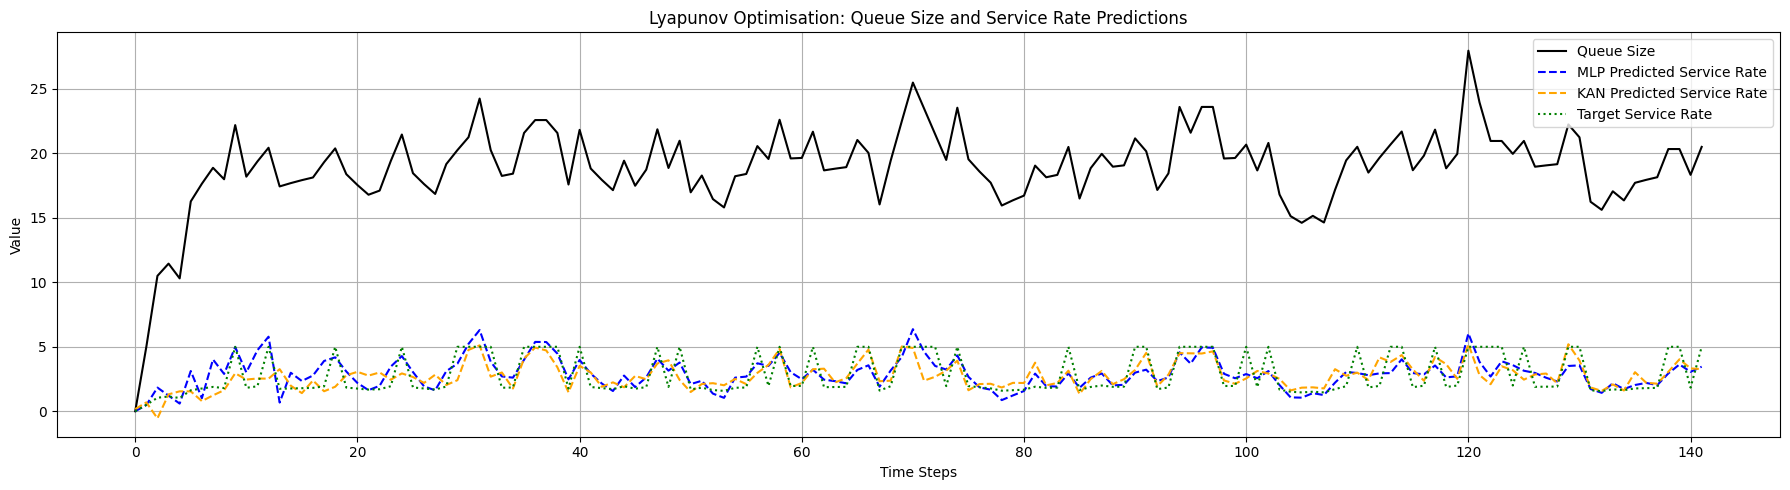

In [67]:
xTest, yTest = generateStochasticSamples(tSteps=T, seed=0)
queueSizes = xTest[:, 0]
xTensor = torch.tensor(xTest, dtype=torch.float32)
mlpModel.eval()
with torch.no_grad():
    mlpPredictions = mlpModel(xTensor).squeeze().detach().numpy()

kModel.eval()
with torch.no_grad():
    kanPredictions = kModel(xTensor).squeeze().detach().numpy()

epochLimit = 1000

plt.figure(figsize=(18, 5))
plt.plot(queueSizes[:epochLimit], label="Queue Size", color='black')
plt.plot(mlpPredictions[:epochLimit], label="MLP Predicted Service Rate", linestyle="--", color='blue')
plt.plot(kanPredictions[:epochLimit], label="KAN Predicted Service Rate", linestyle="--", color='orange')
plt.plot(yTest[:epochLimit], label="Target Service Rate", linestyle="dotted", color='green')

plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.title("Lyapunov Optimisation: Queue Size and Service Rate Predictions")
plt.grid()
plt.tight_layout()
plt.show()


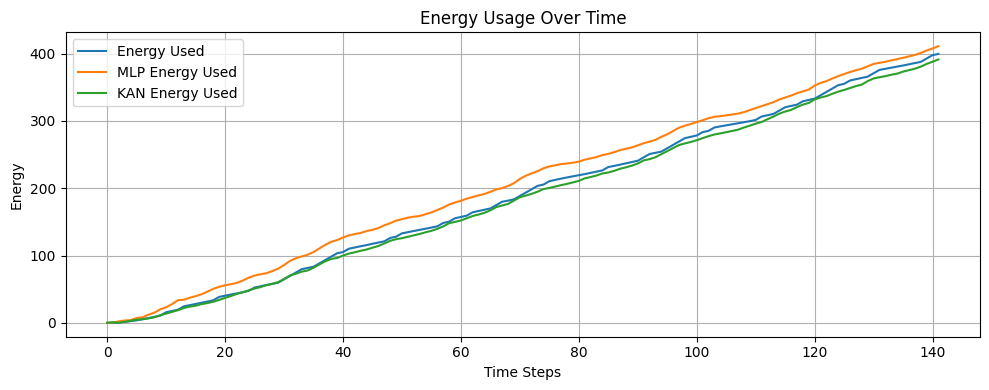

In [68]:
plt.figure(figsize=(10, 4))
plt.plot(xTest[:, 1], label="Energy Used")
plt.plot(np.cumsum(mlpPredictions), label="MLP Energy Used")
plt.plot(np.cumsum(kanPredictions), label="KAN Energy Used")
plt.xlabel("Time Steps")
plt.ylabel("Energy")
plt.title("Energy Usage Over Time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

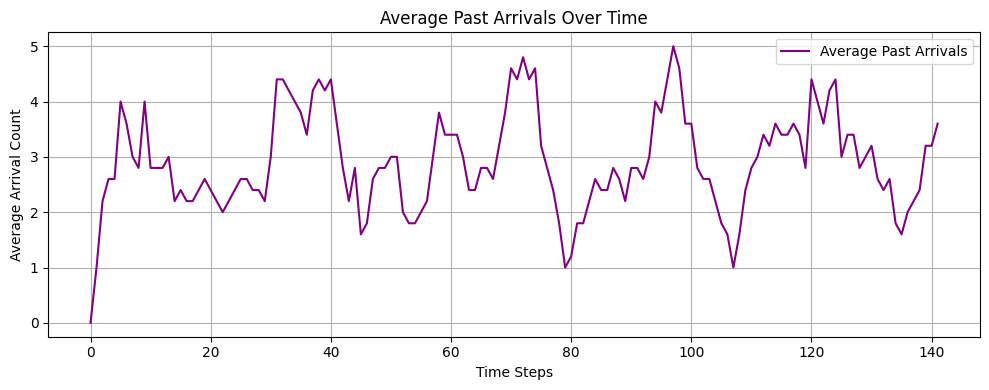

In [69]:
# Calculate the average past arrival per timestep
avgPastArrivals = np.mean(xTest[:, 2:], axis=1)

# Plot the average past arrivals
plt.figure(figsize=(10, 4))
plt.plot(avgPastArrivals, label="Average Past Arrivals", color='purple')
plt.xlabel("Time Steps")
plt.ylabel("Average Arrival Count")
plt.title("Average Past Arrivals Over Time")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


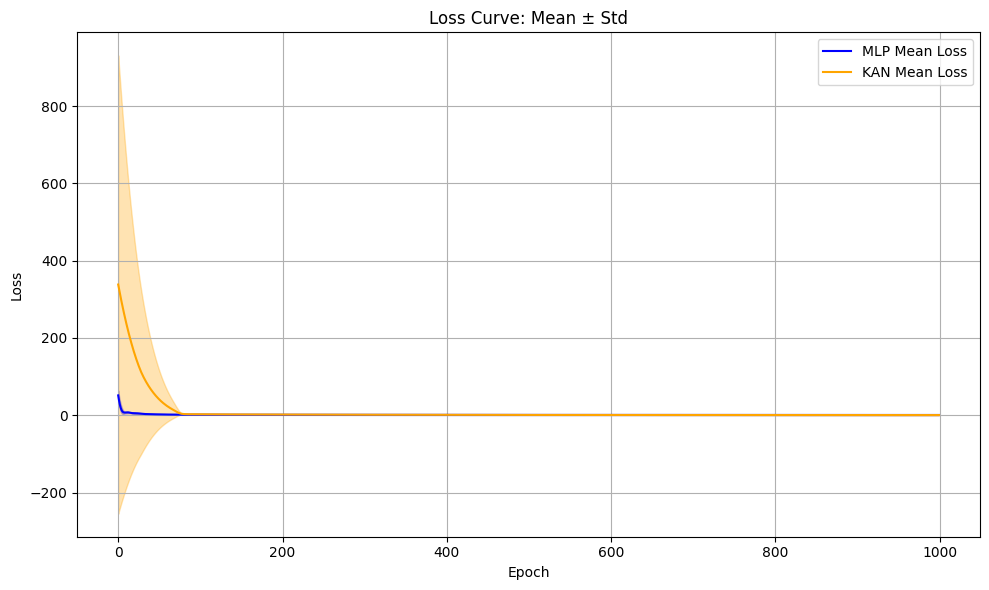

In [ ]:
# Plot mean ± std of loss for MLP and KAN
mlpLossArray = np.array(mlpLossesAll)
kanLossArray = np.array(kanLossesAll)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color="blue")
plt.fill_between(range(len(mlpMeanLoss)), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss, alpha=0.3, color="blue")

plt.plot(kanMeanLoss, label="KAN Mean Loss", color="orange")
plt.fill_between(range(len(kanMeanLoss)), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss, alpha=0.3, color="orange")

plt.title("Loss Curve: Mean ± Std")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\A\AppData\Local\Temp\ipykernel_44368\2795249411.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mlpJumpCounts, kanJumpCounts], labels=["MLP", "KAN"])


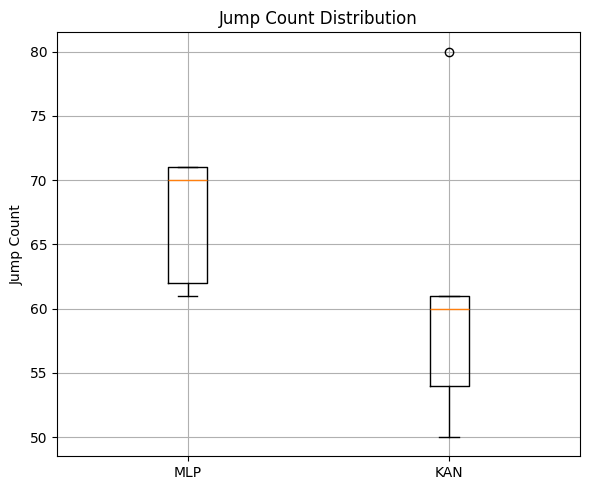

In [71]:
plt.figure(figsize=(6, 5))
plt.boxplot([mlpJumpCounts, kanJumpCounts], labels=["MLP", "KAN"])
plt.title("Jump Count Distribution")
plt.ylabel("Jump Count")
plt.grid(True)
plt.tight_layout()
plt.show()


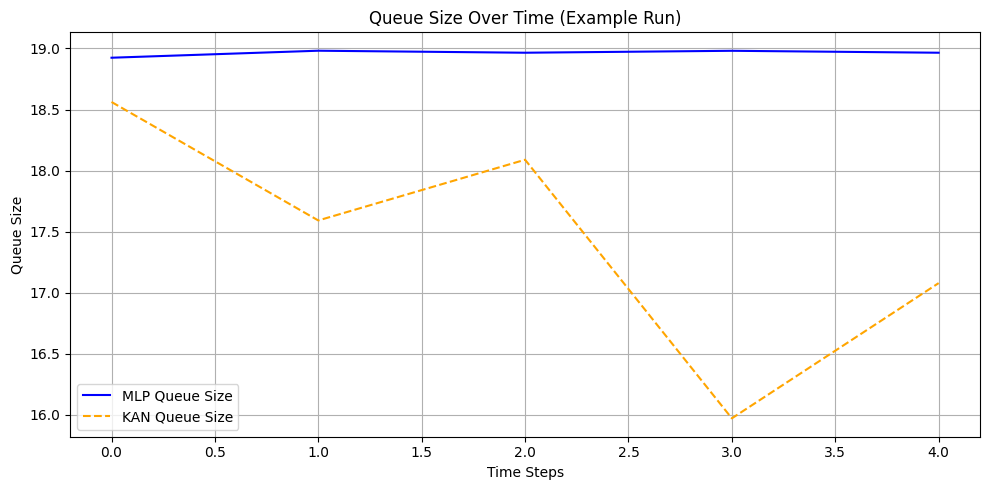

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(mlpAvgQueues, label="MLP Queue Size", color="blue")
plt.plot(kanAvgQueues, label="KAN Queue Size", color="orange", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Queue Size")
plt.title("Queue Size Over Time (Example Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


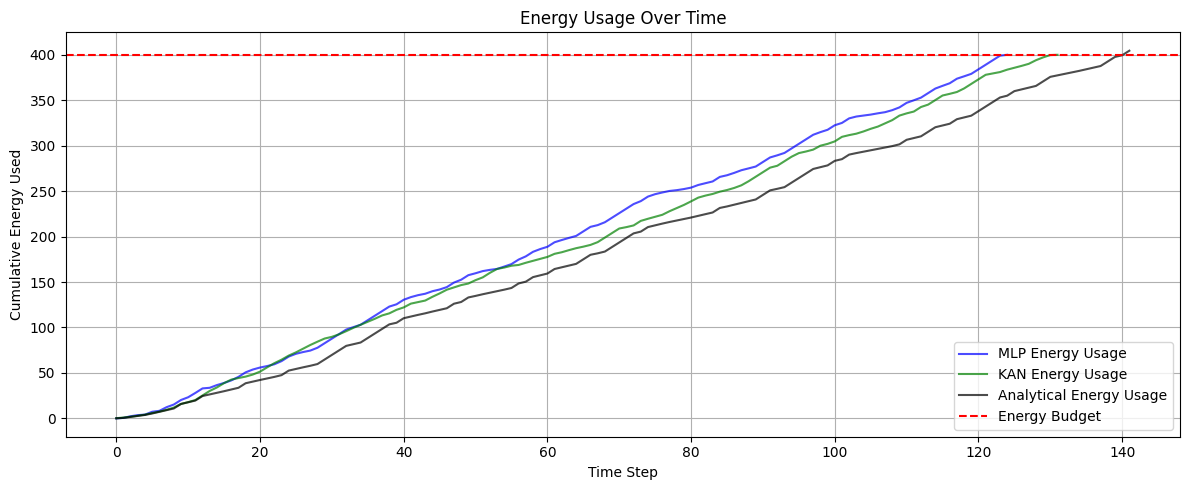

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(np.cumsum(mlpServiceRates), label="MLP Energy Usage", color='blue', alpha=0.7)
plt.plot(np.cumsum(serviceRates), label="KAN Energy Usage", color='green', alpha=0.7)
plt.plot(np.cumsum(analyticalServiceRates), label="Analytical Energy Usage", color='black', alpha=0.7)
plt.axhline(energyBudget, color='red', linestyle='--', label="Energy Budget")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Energy Used")
plt.title("Energy Usage Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [75]:
import pickle

mlpResults = {
    "finalLosses": mlpLossesAll,             
    "summaries": mlpSummary,                 
    "avgQueues": [s["avgQueue"] for s in mlpSummary],
    "avgServices": [s["avgService"] for s in mlpSummary],
    "totalEnergies": [s["totalEnergy"] for s in mlpSummary],
    "jumpCounts": [s["jumpCount"] for s in mlpSummary],
    "times": [s["time"] for s in mlpSummary]
}

kanResults = {
    "finalLosses": kanLossesAll,              
    "summaries": kanSummary,                  
    "avgQueues": [s["avgQueue"] for s in kanSummary],
    "avgServices": [s["avgService"] for s in kanSummary],
    "totalEnergies": [s["totalEnergy"] for s in kanSummary],
    "jumpCounts": [s["jumpCount"] for s in kanSummary],
    "times": [s["time"] for s in kanSummary]
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)